In [173]:
from params import *
from mass_assign import CIC_3D
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel, detect_threshold,  detect_sources
from photutils.isophote import Ellipse, EllipseGeometry, build_ellipse_model
from photutils import EllipticalAperture

## Figure 1

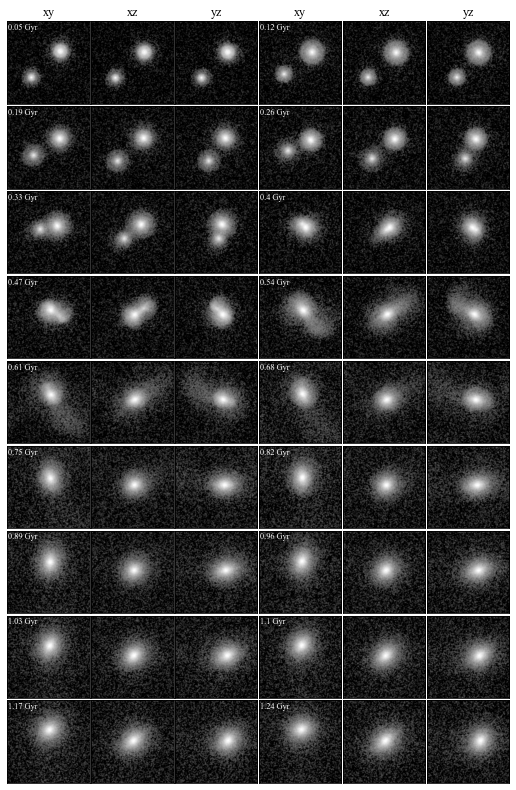

In [202]:
snapshot = np.arange(5, 125, 7)
plt.figure(figsize=(9, len(snapshot)*1.56/2))
for n,i in enumerate(snapshot):
    part = np.load("./data/" + str(i) + ".npy")
    
    dens = CIC_3D(part)
    kernel = make_2dgaussian_kernel(fwhm=5, size=15)
    
    plt.subplot(len(snapshot)//2,6,3*n+1)
    intens = convolve(np.sum(dens, axis=0) + np.random.randn(512, 512)*.1, kernel)
    intens[intens < 0] = 0
    plt.imshow(np.log(intens + .01), cmap="gray", origin="lower")
    plt.xticks([]); plt.yticks([]); 
    plt.text(5, 500, str(round(i*0.01, 2))+" Gyr", c="w", ha="left", va="top", fontsize="small")
    if n < 2: plt.title("xy")
    plt.subplot(len(snapshot)//2,6,3*n+2)
    intens = convolve(np.sum(dens, axis=1) + np.random.randn(512, 512)*.1, kernel)
    intens[intens < 0] = 0
    plt.imshow(np.log(intens + .01), cmap="gray", origin="lower")
    plt.xticks([]); plt.yticks([]) 
    if n < 2: plt.title("xz")
    plt.subplot(len(snapshot)//2,6,3*n+3)
    intens = convolve(np.sum(dens, axis=2) + np.random.randn(512, 512)*.1, kernel)
    intens[intens < 0] = 0
    plt.imshow(np.log(intens + .01), cmap="gray", origin="lower")
    plt.xticks([]); plt.yticks([]) 
    if n < 2: plt.title("yz")
    
plt.subplots_adjust(wspace=0.02, hspace=0.01)
plt.savefig("merging.pdf", dpi=150)

## Measure f_tidal

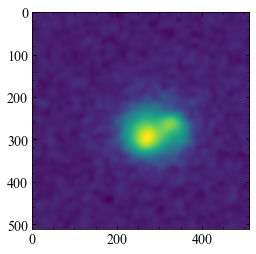

/Users/huang/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/huang/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/huang/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/huang/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/huang/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


270.26708885997954 295.2530961775473


In [391]:
i = 45
part = np.load("./data/" + str(i) + ".npy")
    
dens = CIC_3D(part)
kernel = make_2dgaussian_kernel(fwhm=15, size=61)

intens = convolve(np.sum(dens, axis=0) + np.random.randn(512, 512)*.1, kernel)
plt.imshow(np.log(intens +.05))
plt.show()

img_masked = intens
DIM = 512

params = {}
params['e0'] = 0.2
params['pa0'] = 0
params['sma0'] = 20
params['xcen0'] = 270
params['ycen0'] = 300
params['pixscl'] = 1

# find center
geometry = EllipseGeometry(params['xcen0'], params['ycen0'], params['sma0'], params['e0'], params['pa0'])
ellipse = Ellipse(img_masked, geometry)
iso_free = ellipse.fit_image(fix_center=False, fix_pa=False, fix_eps=False, 
                             minsma=.2, maxsma=DIM/2*1.35, step=0.15, maxgerr=10)

kk = iso_free.sma*params['pixscl'] < 10
xcen = np.mean(iso_free.x0[kk])
ycen = np.mean(iso_free.y0[kk])
params.update({'xcen':xcen, 'ycen':ycen})
print(xcen, ycen)

# fixed center
geometry = EllipseGeometry(params['xcen'], params['ycen'], params['sma0'], params['e0'], params['pa0'])
ellipse = Ellipse(img_masked, geometry)

iso_fixCen = ellipse.fit_image(fix_center=True, fix_pa=False, fix_eps=False, 
                               minsma=.2, maxsma=DIM/2*1.3, step=0.1, maxgerr=1)

In [392]:
model_image = build_ellipse_model(img_masked.shape, iso_fixCen)

0.130058


/var/folders/00/2yrskd3n7sn998vb8h_qcq9m0000gn/T/ipykernel_4561/3187568414.py:3: RuntimeWarning: divide by zero encountered in true_divide
  mask = (intens/model_image <= 1.15) | (intens < rms)


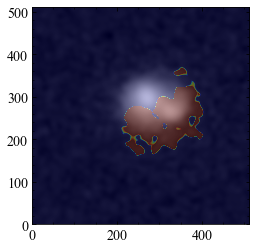

In [393]:
rms = detect_threshold(intens, nsigma=3)
residual = intens - model_image
mask = (intens/model_image <= 1.15) | (intens < rms)
residual[mask] = 0
segm = detect_sources(residual, threshold=0, npixels=200)
mask = mask | (segm.data<1)
residual[mask] = 0

plt.imshow(np.log(intens + .05), origin="lower", cmap="gray")
plt.imshow(residual, cmap="jet", origin="lower", alpha=.3, vmax=.01)

ftidal = round(np.sum(residual) / (np.sum(model_image) + np.sum(residual)), 6)
print(ftidal)

f_tidal = pd.read_csv("f_tidal.csv")

f_tidal.loc[np.where(f_tidal["i"] == i)[0][0], "ftidal"] = ftidal
f_tidal.to_csv("f_tidal.csv", index=None)

## Figure 2

0.12000000000000001 -9.00000001868942 0.010000000000000002


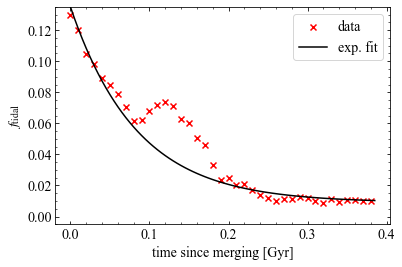

In [457]:
plt.rcParams["font.size"] = 14
f_tidal = pd.read_csv("f_tidal.csv")
plt.scatter((f_tidal["i"][45:84]-45)*.01, f_tidal["ftidal"][45:84], marker="x", c="r")
plt.ylim(-0.005, 0.135)

expx = np.arange(0, 0.39, 0.005)
a, b, c = 0.126, -11.9, 0.009
plt.plot(expx, a * np.exp(b * expx) + c, c="k")
plt.xlabel("time since merging [Gyr]")
plt.ylabel("$f_\mathrm{tidal}$")
plt.legend(("data", "exp. fit"))
plt.savefig("f_tidal.pdf", dpi=250)